In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm

In [2]:
REBUILD_DATA = False

class DogsVSCats():
    IMG_SIZE = 50
    CATS = "PetImages/Cat"
    DOGS = "PetImages/Dog"
    LABELS = {CATS: 0, DOGS: 1}
    
    training_data = []
    catcount = 0
    dogcount = 0
    
    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label, f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])

                    if label == self.CATS:
                        self.catcount += 1
                    elif label == self.DOGS:
                        self.dogcount += 1
                except Exception as e:
                    pass
                    
        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print("Cats:", self.catcount)
        print("Dogs:", self.dogcount)

    
if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()
    

In [3]:
training_data = np.load("training_data.npy", allow_pickle=True)

In [4]:
training_data.shape

(24946, 2)

In [5]:
training_data[0]

array([array([[ 80, 216, 221, ..., 197, 199, 203],
       [101, 155, 220, ..., 196, 200, 203],
       [219,  87, 220, ..., 196, 200, 205],
       ...,
       [233, 232, 237, ..., 236, 236, 237],
       [239, 242, 237, ..., 240, 236, 235],
       [235, 239, 240, ..., 231, 232, 239]], dtype=uint8),
       array([0., 1.])], dtype=object)

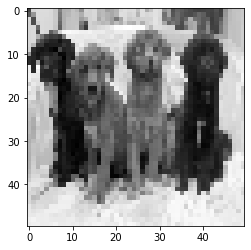

In [6]:
import matplotlib.pyplot as plt

plt.imshow(training_data[0][0], cmap='gray')

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [31]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        self.flat1 = nn.Flatten()
        
        x = torch.randn(50,50).view(-1,1,50,50)
        
        self.convs(x)
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 2)
        
    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))
#         print(x[0].shape)
        x = self.flat1(x)
#         print(x.shape)
        
        self._to_linear = x.shape[1]
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (flat1): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


In [32]:
import torch.optim as optim

X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)
X = X/255.0 # scale images
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1  # lets reserve 10% of our data for validation
val_size = int(len(X)*VAL_PCT)
print(val_size)

2494


In [33]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X), len(test_X))

22452 2494


In [34]:
BATCH_SIZE = 100
EPOCHS = 1

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)): # from 0, to the len of x, stepping BATCH_SIZE at a time. [:50] ..for now just to dev
        #print(f"{i}:{i+BATCH_SIZE}")
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = train_y[i:i+BATCH_SIZE]

        net.zero_grad()

        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()    # Does the update

    print(f"Epoch: {epoch}. Loss: {loss}")

100%|██████████| 225/225 [00:32<00:00,  6.91it/s]

Epoch: 0. Loss: 0.23251387476921082


In [35]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1, 1, 50, 50))[0]  # returns a list, 
        predicted_class = torch.argmax(net_out)

        if predicted_class == real_class:
            correct += 1
        total += 1
print("Accuracy: ", round(correct/total, 3))

100%|██████████| 2494/2494 [00:02<00:00, 873.65it/s]

Accuracy:  0.628


In [36]:
torch.cuda.is_available()

True

In [45]:
device = torch.device("cuda:0")
device

device(type='cuda', index=0)

In [44]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on GPU")
else:
    device = torch.device("cpu")
    print("Running on CPU")
    


Running on GPU


In [40]:
torch.cuda.device_count()

1

In [41]:
net.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (flat1): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

In [42]:
net = Net().to(device)

In [51]:
# setup to run on GPU
BATCH_SIZE = 100
EPOCHS = 10

def train(net):
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    loss_function = nn.MSELoss()

    for epoch in range(EPOCHS):
        for i in tqdm(range(0, len(train_X), BATCH_SIZE)): # from 0, to the len of x, stepping BATCH_SIZE at a time. [:50] ..for now just to dev
            #print(f"{i}:{i+BATCH_SIZE}")
            batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50).to(device)
            batch_y = train_y[i:i+BATCH_SIZE].to(device)

            net.zero_grad()

            outputs = net(batch_X)
            loss = loss_function(outputs, batch_y)
            loss.backward()
            optimizer.step()    # Does the update

        print(f"Epoch: {epoch}. Loss: {loss}")
        
train(net)

  2%|▏         | 5/225 [00:00<00:05, 40.55it/s]

Epoch: 0. Loss: 0.19146214425563812


  2%|▏         | 5/225 [00:00<00:05, 40.69it/s]

Epoch: 1. Loss: 0.16951535642147064


  2%|▏         | 5/225 [00:00<00:05, 40.28it/s]

Epoch: 2. Loss: 0.14567428827285767


  2%|▏         | 5/225 [00:00<00:05, 40.55it/s]

Epoch: 3. Loss: 0.13045461475849152


  2%|▏         | 5/225 [00:00<00:05, 41.12it/s]

Epoch: 4. Loss: 0.11292610317468643


  2%|▏         | 5/225 [00:00<00:05, 38.36it/s]

Epoch: 5. Loss: 0.11062615364789963


  2%|▏         | 5/225 [00:00<00:05, 39.27it/s]

Epoch: 6. Loss: 0.0936165601015091


  2%|▏         | 5/225 [00:00<00:05, 39.31it/s]

Epoch: 7. Loss: 0.08574098348617554


  2%|▏         | 5/225 [00:00<00:05, 39.02it/s]

Epoch: 8. Loss: 0.08974181115627289


100%|██████████| 225/225 [00:06<00:00, 33.43it/s]

Epoch: 9. Loss: 0.09498760849237442


In [52]:
def test(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for i in tqdm(range(len(test_X))):
            real_class = torch.argmax(test_y[i]).to(device)
            net_out = net(test_X[i].view(-1, 1, 50, 50).to(device))[0]  # returns a list, 
            predicted_class = torch.argmax(net_out)

            if predicted_class == real_class:
                correct += 1
            total += 1
    print("Accuracy: ", round(correct/total, 3))
    
test(net)

100%|██████████| 2494/2494 [00:02<00:00, 905.16it/s]

Accuracy:  0.715
